In [ ]:
!pip install -Uqq librosa

In [ ]:
from fastai.vision.all import *
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
path = Path('/content/drive/MyDrive/VoiceRecognition/Dataset')

In [14]:
data = get_files(path, extensions='.wav')
data

(#1321) [Path('/content/drive/MyDrive/VoiceRecognition/Dataset/Agustin_Lopez/Agustin_Lopez_Principito_1.wav'),Path('/content/drive/MyDrive/VoiceRecognition/Dataset/Agustin_Lopez/Agustin_Lopez_Principito_0.wav'),Path('/content/drive/MyDrive/VoiceRecognition/Dataset/Agustin_Lopez/Agustin_Lopez_Principito_3.wav'),Path('/content/drive/MyDrive/VoiceRecognition/Dataset/Agustin_Lopez/Agustin_Lopez_Principito_7.wav'),Path('/content/drive/MyDrive/VoiceRecognition/Dataset/Agustin_Lopez/Agustin_Lopez_Principito_6.wav'),Path('/content/drive/MyDrive/VoiceRecognition/Dataset/Agustin_Lopez/Agustin_Lopez_Principito_9.wav'),Path('/content/drive/MyDrive/VoiceRecognition/Dataset/Agustin_Lopez/Agustin_Lopez_Principito_8.wav'),Path('/content/drive/MyDrive/VoiceRecognition/Dataset/Agustin_Lopez/Agustin_Lopez_Principito_5.wav'),Path('/content/drive/MyDrive/VoiceRecognition/Dataset/Agustin_Lopez/Agustin_Lopez_Principito_10.wav'),Path('/content/drive/MyDrive/VoiceRecognition/Dataset/Agustin_Lopez/Agustin_Lopez

In [ ]:
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


In [ ]:
audio_test, sample_rate = torchaudio.load(data[500])
spectrogram = T.Spectrogram(n_fft=512)

#n_fft = 1024
n_fft = 1024
win_length = None
#hop_length = 512
hop_length = None
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    n_mels=n_mels,
    mel_scale="htk",
)


In [ ]:
sample_rate

48000

In [ ]:
Audio(audio_test, rate=sample_rate)

In [ ]:
def show_data(waveform):
  audio, sample_rate = torchaudio.load(waveform)
  spec = mel_spectrogram(audio)
  fig, axs = plt.subplots(2, 1)
  plot_waveform(audio, sample_rate, ax=axs[0])
  plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
  fig.tight_layout()
  display(Audio(audio, rate=sample_rate))


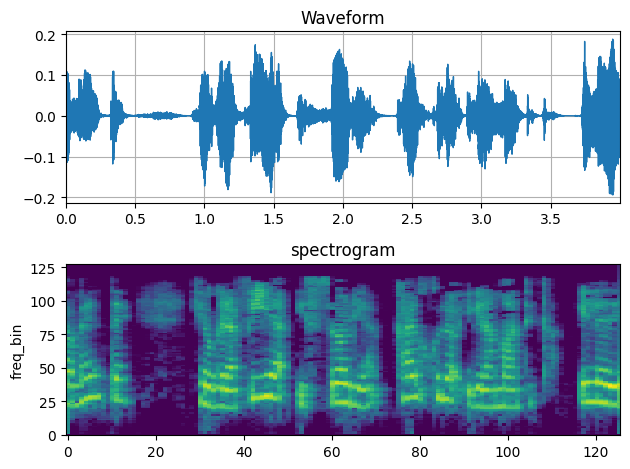

In [ ]:
show_data(data[700])

In [15]:
# We will train using the image dataset
img_path = Path('/content/drive/MyDrive/VoiceRecognition/DatasetImages')


In [6]:
#Create data block to load data into resnet18 for finetunning
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=69),
    get_y=parent_label,
).dataloaders(img_path)

dls.bs

64

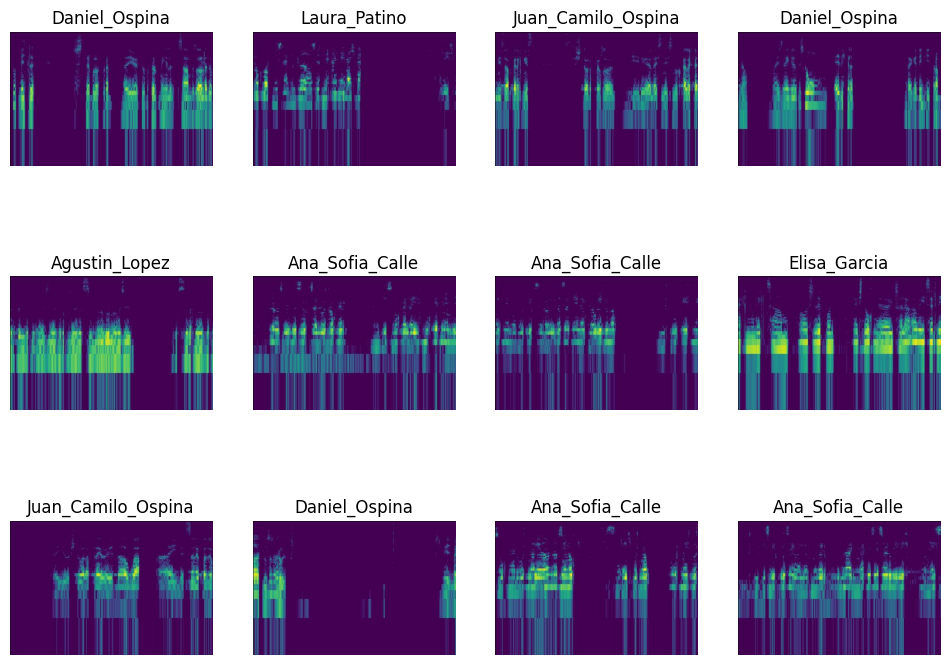

In [7]:
dls.show_batch(max_n=12) #

In [8]:
# Load data to learner for training
learn = vision_learner(dls, xresnet18, metrics=error_rate)

Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to /root/.cache/torch/hub/checkpoints/xrn50_940.pth
100%|██████████| 244M/244M [00:16<00:00, 15.1MB/s]


SuggestedLRs(valley=0.0012022644514217973)

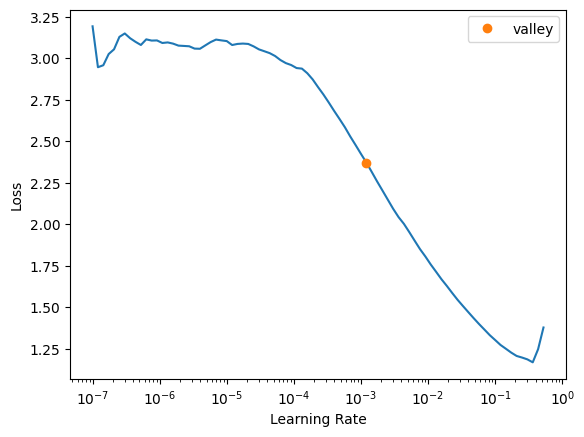

In [9]:
#Find an optimal learning rate
learn.lr_find()

In [10]:
learn.fine_tune(12, 0.00012)


epoch,train_loss,valid_loss,error_rate,time
0,2.832088,1.852528,0.833333,01:54


epoch,train_loss,valid_loss,error_rate,time
0,2.014812,1.402789,0.594697,00:14
1,1.906845,1.061357,0.416667,00:13
2,1.692821,0.780444,0.306818,00:13
3,1.468800,0.598279,0.227273,00:13
4,1.284517,0.469209,0.196970,00:13
5,1.115026,0.409464,0.155303,00:13
6,0.968128,0.350011,0.128788,00:13
7,0.850107,0.323872,0.109848,00:13
8,0.755762,0.318114,0.128788,00:13
9,0.687659,0.304152,0.106061,00:14


In [17]:
learn.export('/content/drive/MyDrive/VoiceRecognition/voice_classifier_hankel_v1.pkl')

In [ ]:
learn.eval()

Sequential(
  (0): Sequential(
    (0): ConvLayer(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): ConvLayer(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): ConvLayer(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): ResBlock(
        (convpath): Sequential(
          (0): ConvLayer(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): Ba

In [11]:
interp = ClassificationInterpretation.from_learner(learn)

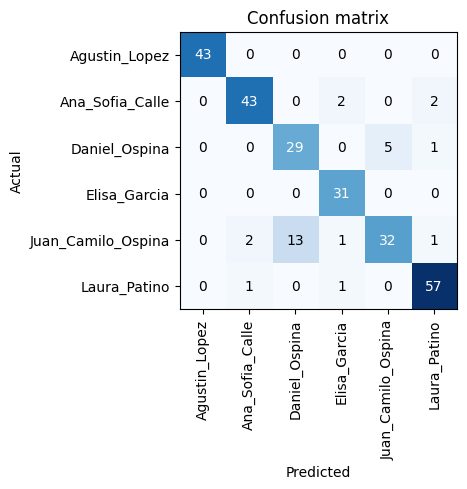

In [12]:
interp.plot_confusion_matrix()

In [19]:
voice_classf = load_learner('/content/drive/MyDrive/VoiceRecognition/voice_classifier_hankel_v1.pkl')

## Lets Test the Model


In [20]:
test_path = '/content/drive/MyDrive/VoiceRecognition/TestHankel'
person_path = '/Elisa_Garcia/Elisa_Garcia_Test_19.jpg'
person,_,probability = voice_classf.predict(PILImage.create(test_path + person_path))
print(f'This is : {person}')
print(f'Chances: {1-probability[0]:.4f}')


This is : Elisa_Garcia
Chances: 0.9334


In [21]:
test_data = get_files(test_path, extensions='.jpg')
test_data

(#453) [Path('/content/drive/MyDrive/VoiceRecognition/TestHankel/Juan_Camilo_Ospina/Juan_Camilo_Ospina_Test_7.jpg'),Path('/content/drive/MyDrive/VoiceRecognition/TestHankel/Juan_Camilo_Ospina/Juan_Camilo_Ospina_Test_6.jpg'),Path('/content/drive/MyDrive/VoiceRecognition/TestHankel/Juan_Camilo_Ospina/Juan_Camilo_Ospina_Test_9.jpg'),Path('/content/drive/MyDrive/VoiceRecognition/TestHankel/Juan_Camilo_Ospina/Juan_Camilo_Ospina_Test_1.jpg'),Path('/content/drive/MyDrive/VoiceRecognition/TestHankel/Juan_Camilo_Ospina/Juan_Camilo_Ospina_Test_0.jpg'),Path('/content/drive/MyDrive/VoiceRecognition/TestHankel/Juan_Camilo_Ospina/Juan_Camilo_Ospina_Test_8.jpg'),Path('/content/drive/MyDrive/VoiceRecognition/TestHankel/Juan_Camilo_Ospina/Juan_Camilo_Ospina_Test_4.jpg'),Path('/content/drive/MyDrive/VoiceRecognition/TestHankel/Juan_Camilo_Ospina/Juan_Camilo_Ospina_Test_5.jpg'),Path('/content/drive/MyDrive/VoiceRecognition/TestHankel/Juan_Camilo_Ospina/Juan_Camilo_Ospina_Test_3.jpg'),Path('/content/drive

In [22]:
l_str = str(test_data[400]).split('/')
l_str[6]

'Elisa_Garcia'

In [23]:
total = len(test_data)
total

453

In [24]:
correct = 0
actual_lst = []
pred_lst = []
category = []
for test in test_data:
  actual = str(test).split('/')[6]
  pred,_,probability = voice_classf.predict(PILImage.create(test))
  if pred == actual:
    correct += 1
  actual_lst.append(actual)
  pred_lst.append(pred)
  if actual not in category: category.append(actual)



print(f'Acuracy: {(correct/total) * 100}%')



Acuracy: 77.70419426048565%


In [25]:
category

['Juan_Camilo_Ospina',
 'Ana_Sofia_Calle',
 'Agustin_Lopez',
 'Daniel_Ospina',
 'Laura_Patino',
 'Elisa_Garcia']

In [26]:
conf_mat = confusion_matrix(actual_lst, pred_lst, labels=category)
conf_mat

array([[58,  0,  0, 15,  2,  0],
       [ 0, 62,  0,  0, 10,  2],
       [ 0,  0, 75,  0,  0,  0],
       [19,  0,  0, 55,  1,  0],
       [ 2, 29,  0,  3, 38,  6],
       [ 1,  6,  0,  2,  3, 64]])

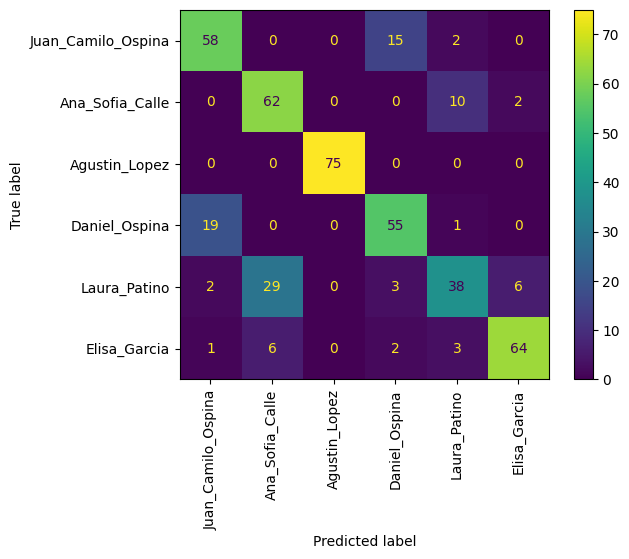

In [27]:
disp = ConfusionMatrixDisplay(conf_mat, display_labels=category)
disp.plot(xticks_rotation='vertical', cmap='viridis')
plt.show()